In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [3]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [4]:
from transunet import TransUNet

In [16]:
class SegDataNp(Dataset):

    def __init__(self,image_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        file =  np.load(self.image_paths[index])

        image = file[0]
        mask = file[1]

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(torch.unsqueeze(image,dim=0),dim=0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
            
        image = image.squeeze()
        mask = mask.squeeze()
        
        sample = {'image':image,'mask':mask}

        return sample

In [32]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/train_files'
total_input_files = []
for file in os.listdir(data_dir):
    if file.endswith('.npy'):
        total_input_files.append(os.path.join(data_dir,file))

In [12]:
from tqdm import tqdm

In [13]:
import gc

In [49]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    model = TransUNet(img_dim=128,
                          in_channels=1,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=4)
    model.to(device)
    epochs = 100
    loss_func = torch.nn.CrossEntropyLoss(weight = torch.tensor([0.0043484 , 0.3454297 , 0.32142933, 0.32879258])) # calculated class imbalance weight
    loss_func.to(device)
#     optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01,momentum = 0.9, weight_decay = 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-4)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_q3_transunet')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img = train_test_split(total_input_files,test_size=0.2,random_state=seed)
    train_data = SegDataNp(image_paths = train_img,img_mean=90,img_std=101) # calculated mean and std of the bianry images.
    valid_data = SegDataNp(image_paths = valid_img,img_mean=90,img_std=101)
    train_dataloader = DataLoader(train_data,batch_size = 8,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 8,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
            
            image = torch.unsqueeze(image,axis = 1)
            mask = torch.unsqueeze(mask,axis = 1)
            
            #print(image.size())
            #print(mask.size())
            
            
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.squeeze(mask_final)
            #print(mask_final.shape)
            
            #break
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
            #break
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                
        #break
        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = torch.unsqueeze(batch['image'],1).to(device)
            final_mask = batch['mask'].to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
            #break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [50]:
train()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 1.01940
The average loss for the epoch is 0.8846340660025312
The average validation loss for the epoch is 0.79956


  1%|          | 1/100 [00:57<1:34:55, 57.53s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.65372
The average loss for the epoch is 0.6347723041529431
The average validation loss for the epoch is 0.49662


  2%|▏         | 2/100 [01:57<1:35:50, 58.68s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.58080
The average loss for the epoch is 0.5632246734272123
The average validation loss for the epoch is 1.06708


  3%|▎         | 3/100 [02:59<1:37:25, 60.26s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.49333
The average loss for the epoch is 0.505714689717867
The average validation loss for the epoch is 0.42882


  4%|▍         | 4/100 [03:53<1:32:56, 58.09s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.47309
The average loss for the epoch is 0.4727535321138292
The average validation loss for the epoch is 0.42288


  5%|▌         | 5/100 [04:52<1:32:20, 58.32s/it]

Epoch 6
	Batch Loss for curent for 99 is 0.42076
The average loss for the epoch is 0.43503427599113026
The average validation loss for the epoch is 0.40208


  6%|▌         | 6/100 [05:52<1:32:00, 58.73s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.41536
The average loss for the epoch is 0.42265645902194277
The average validation loss for the epoch is 0.51279


  7%|▋         | 7/100 [06:52<1:31:44, 59.19s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.42130
The average loss for the epoch is 0.4058116536333923
The average validation loss for the epoch is 0.33733


  8%|▊         | 8/100 [07:53<1:31:47, 59.86s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.41600
The average loss for the epoch is 0.3954819576590473
The average validation loss for the epoch is 0.33532


  9%|▉         | 9/100 [08:51<1:29:48, 59.22s/it]

Epoch 10
	Batch Loss for curent for 99 is 0.36100
The average loss for the epoch is 0.367760700315081
The average validation loss for the epoch is 0.32965


 10%|█         | 10/100 [09:49<1:28:28, 58.98s/it]

Epoch 11
	Batch Loss for curent for 99 is 0.35256
The average loss for the epoch is 0.35284948263180815
The average validation loss for the epoch is 0.30302


 11%|█         | 11/100 [10:49<1:27:45, 59.16s/it]

Epoch 12
	Batch Loss for curent for 99 is 0.32843
The average loss for the epoch is 0.3427073421122516
The average validation loss for the epoch is 0.33613


 12%|█▏        | 12/100 [11:49<1:27:06, 59.40s/it]

Epoch 13
	Batch Loss for curent for 99 is 0.33724
The average loss for the epoch is 0.33377498162042407
The average validation loss for the epoch is 0.32028


 13%|█▎        | 13/100 [12:51<1:27:15, 60.18s/it]

Epoch 14
	Batch Loss for curent for 99 is 0.32152
The average loss for the epoch is 0.3222259985994918
The average validation loss for the epoch is 0.33439


 14%|█▍        | 14/100 [13:48<1:25:02, 59.34s/it]

Epoch 15
	Batch Loss for curent for 99 is 0.30595
The average loss for the epoch is 0.30899512822403336
The average validation loss for the epoch is 0.29219


 15%|█▌        | 15/100 [14:46<1:23:23, 58.86s/it]

Epoch 16
	Batch Loss for curent for 99 is 0.30832
The average loss for the epoch is 0.3070900880229411
The average validation loss for the epoch is 0.27164


 16%|█▌        | 16/100 [15:45<1:22:25, 58.88s/it]

Epoch 17
	Batch Loss for curent for 99 is 0.29158
The average loss for the epoch is 0.2924840908244018
The average validation loss for the epoch is 0.26924


 17%|█▋        | 17/100 [16:45<1:21:52, 59.19s/it]

Epoch 18
	Batch Loss for curent for 99 is 0.33420
The average loss for the epoch is 0.3372384023447936
The average validation loss for the epoch is 0.30523


 18%|█▊        | 18/100 [17:45<1:21:07, 59.36s/it]

Epoch 19
	Batch Loss for curent for 99 is 0.32084
The average loss for the epoch is 0.31371086890472794
The average validation loss for the epoch is 0.24880


 19%|█▉        | 19/100 [18:40<1:18:39, 58.27s/it]

Epoch 20
	Batch Loss for curent for 99 is 0.28355
The average loss for the epoch is 0.2812745836392747
The average validation loss for the epoch is 0.24740


 20%|██        | 20/100 [19:36<1:16:42, 57.53s/it]

Epoch 21
	Batch Loss for curent for 99 is 0.29370
The average loss for the epoch is 0.2851372379126973
The average validation loss for the epoch is 0.22904


 21%|██        | 21/100 [20:32<1:15:05, 57.03s/it]

Epoch 22
	Batch Loss for curent for 99 is 0.28027
The average loss for the epoch is 0.276994836892133
The average validation loss for the epoch is 0.24829


 22%|██▏       | 22/100 [21:27<1:13:14, 56.34s/it]

Epoch 23
	Batch Loss for curent for 99 is 0.27197
The average loss for the epoch is 0.27009619312136585
The average validation loss for the epoch is 0.22714


 23%|██▎       | 23/100 [22:24<1:12:46, 56.71s/it]

Epoch 24
	Batch Loss for curent for 99 is 0.26928
The average loss for the epoch is 0.26742746084148344
The average validation loss for the epoch is 0.23090


 24%|██▍       | 24/100 [23:23<1:12:34, 57.30s/it]

Epoch 25
	Batch Loss for curent for 99 is 0.26543
The average loss for the epoch is 0.2643985934750572
The average validation loss for the epoch is 0.26603


 25%|██▌       | 25/100 [24:19<1:11:01, 56.83s/it]

Epoch 26
	Batch Loss for curent for 99 is 0.25783
The average loss for the epoch is 0.2561126737538433
The average validation loss for the epoch is 0.23443


 26%|██▌       | 26/100 [25:15<1:09:54, 56.69s/it]

Epoch 27
	Batch Loss for curent for 99 is 0.24325
The average loss for the epoch is 0.25186025815484414
The average validation loss for the epoch is 0.21970


 27%|██▋       | 27/100 [26:10<1:08:21, 56.19s/it]

Epoch 28
	Batch Loss for curent for 99 is 0.27258
The average loss for the epoch is 0.26320649004731506
The average validation loss for the epoch is 0.21198


 28%|██▊       | 28/100 [27:06<1:07:25, 56.18s/it]

Epoch 29
	Batch Loss for curent for 99 is 0.26080
The average loss for the epoch is 0.25897237986170185
The average validation loss for the epoch is 0.25115


 29%|██▉       | 29/100 [28:03<1:06:32, 56.23s/it]

Epoch 30
	Batch Loss for curent for 99 is 0.25024
The average loss for the epoch is 0.25558104611816207
The average validation loss for the epoch is 0.22726


 30%|███       | 30/100 [29:01<1:06:28, 56.98s/it]

Epoch 31
	Batch Loss for curent for 99 is 0.26518
The average loss for the epoch is 0.25691173955096
The average validation loss for the epoch is 0.21390


 31%|███       | 31/100 [29:57<1:04:58, 56.50s/it]

Epoch 32
	Batch Loss for curent for 99 is 0.24533
The average loss for the epoch is 0.25293682835489045
The average validation loss for the epoch is 0.21934


 32%|███▏      | 32/100 [30:52<1:03:39, 56.17s/it]

Epoch 33
	Batch Loss for curent for 99 is 0.24749
The average loss for the epoch is 0.2402463950879911
The average validation loss for the epoch is 0.21066


 33%|███▎      | 33/100 [31:48<1:02:34, 56.03s/it]

Epoch 34
	Batch Loss for curent for 99 is 0.24043
The average loss for the epoch is 0.2426514683281564
The average validation loss for the epoch is 0.20706


 34%|███▍      | 34/100 [32:43<1:01:12, 55.64s/it]

Epoch 35
	Batch Loss for curent for 99 is 0.25365
The average loss for the epoch is 0.2517318532104892
The average validation loss for the epoch is 0.21460


 35%|███▌      | 35/100 [33:38<1:00:13, 55.59s/it]

Epoch 36
	Batch Loss for curent for 99 is 0.23915
The average loss for the epoch is 0.23941432298478033
The average validation loss for the epoch is 0.21248


 36%|███▌      | 36/100 [34:38<1:00:38, 56.86s/it]

Epoch 37
	Batch Loss for curent for 99 is 0.23600
The average loss for the epoch is 0.23144849666750245
The average validation loss for the epoch is 0.20488


 37%|███▋      | 37/100 [35:34<59:20, 56.52s/it]  

Epoch 38
	Batch Loss for curent for 99 is 0.23073
The average loss for the epoch is 0.22965476252333655
The average validation loss for the epoch is 0.20629


 38%|███▊      | 38/100 [36:31<58:32, 56.66s/it]

Epoch 39
	Batch Loss for curent for 99 is 0.22443
The average loss for the epoch is 0.22754773286936794
The average validation loss for the epoch is 0.22232


 39%|███▉      | 39/100 [37:27<57:34, 56.62s/it]

Epoch 40
	Batch Loss for curent for 99 is 0.22804
The average loss for the epoch is 0.2277182318777314
The average validation loss for the epoch is 0.20800


 40%|████      | 40/100 [38:22<56:08, 56.15s/it]

Epoch 41
	Batch Loss for curent for 99 is 0.22543
The average loss for the epoch is 0.230897331893132
The average validation loss for the epoch is 0.20016


 41%|████      | 41/100 [39:18<55:02, 55.97s/it]

Epoch 42
	Batch Loss for curent for 99 is 0.24918
The average loss for the epoch is 0.23827561892139973
The average validation loss for the epoch is 0.19624


 42%|████▏     | 42/100 [40:17<55:03, 56.96s/it]

Epoch 43
	Batch Loss for curent for 99 is 0.23230
The average loss for the epoch is 0.2258629325328697
The average validation loss for the epoch is 0.19567


 43%|████▎     | 43/100 [41:14<54:01, 56.87s/it]

Epoch 44
	Batch Loss for curent for 99 is 0.22932
The average loss for the epoch is 0.2292007113470457
The average validation loss for the epoch is 0.26541


 44%|████▍     | 44/100 [42:14<54:11, 58.06s/it]

Epoch 45
	Batch Loss for curent for 99 is 0.23900
The average loss for the epoch is 0.23387701512943387
The average validation loss for the epoch is 0.19166


 45%|████▌     | 45/100 [43:18<54:37, 59.60s/it]

Epoch 46
	Batch Loss for curent for 99 is 0.23450
The average loss for the epoch is 0.22638940007586753
The average validation loss for the epoch is 0.20968


 46%|████▌     | 46/100 [44:22<54:52, 60.98s/it]

Epoch 47
	Batch Loss for curent for 99 is 0.21915
The average loss for the epoch is 0.2209026215120136
The average validation loss for the epoch is 0.20152


 47%|████▋     | 47/100 [45:27<54:54, 62.17s/it]

Epoch 48
	Batch Loss for curent for 99 is 0.21064
The average loss for the epoch is 0.21795039467942653
The average validation loss for the epoch is 0.22197


 48%|████▊     | 48/100 [46:30<54:16, 62.63s/it]

Epoch 49
	Batch Loss for curent for 99 is 0.21194
The average loss for the epoch is 0.21284397710992403
The average validation loss for the epoch is 0.19034


 49%|████▉     | 49/100 [47:33<53:17, 62.70s/it]

Epoch 50
	Batch Loss for curent for 99 is 0.21893
The average loss for the epoch is 0.22015132072396304
The average validation loss for the epoch is 0.20047


 50%|█████     | 50/100 [48:37<52:23, 62.87s/it]

Epoch 51
	Batch Loss for curent for 99 is 0.21564
The average loss for the epoch is 0.22090904438058742
The average validation loss for the epoch is 0.18747


 51%|█████     | 51/100 [49:39<51:17, 62.82s/it]

Epoch 52
	Batch Loss for curent for 99 is 0.22974
The average loss for the epoch is 0.22240753300214938
The average validation loss for the epoch is 0.20361


 52%|█████▏    | 52/100 [50:46<51:15, 64.07s/it]

Epoch 53
	Batch Loss for curent for 99 is 0.21393
The average loss for the epoch is 0.2160901564968194
The average validation loss for the epoch is 0.19911


 53%|█████▎    | 53/100 [51:51<50:22, 64.31s/it]

Epoch 54
	Batch Loss for curent for 99 is 0.21287
The average loss for the epoch is 0.21113319624780985
The average validation loss for the epoch is 0.17213


 54%|█████▍    | 54/100 [52:54<49:01, 63.93s/it]

Epoch 55
	Batch Loss for curent for 99 is 0.21030
The average loss for the epoch is 0.2127253681577313
The average validation loss for the epoch is 0.19642


 55%|█████▌    | 55/100 [53:57<47:42, 63.60s/it]

Epoch 56
	Batch Loss for curent for 99 is 0.20515
The average loss for the epoch is 0.21087775906031045
The average validation loss for the epoch is 0.18484


 56%|█████▌    | 56/100 [55:00<46:26, 63.33s/it]

Epoch 57
	Batch Loss for curent for 99 is 0.20223
The average loss for the epoch is 0.20896774717650488
The average validation loss for the epoch is 0.18581


 57%|█████▋    | 57/100 [56:05<45:49, 63.95s/it]

Epoch 58
	Batch Loss for curent for 99 is 0.21065
The average loss for the epoch is 0.21244040740098005
The average validation loss for the epoch is 0.19722


 58%|█████▊    | 58/100 [57:08<44:30, 63.59s/it]

Epoch 59
	Batch Loss for curent for 99 is 0.20573
The average loss for the epoch is 0.20440990107221754
The average validation loss for the epoch is 0.20024


 59%|█████▉    | 59/100 [58:11<43:24, 63.52s/it]

Epoch 60
	Batch Loss for curent for 99 is 0.20880
The average loss for the epoch is 0.20869230131828348
The average validation loss for the epoch is 0.18511


 60%|██████    | 60/100 [59:14<42:10, 63.27s/it]

Epoch 61
	Batch Loss for curent for 99 is 0.20824
The average loss for the epoch is 0.20611728470362917
The average validation loss for the epoch is 0.29923


 61%|██████    | 61/100 [1:00:17<41:08, 63.30s/it]

Epoch 62
	Batch Loss for curent for 99 is 0.29325
The average loss for the epoch is 0.26342463860024956
The average validation loss for the epoch is 0.19960


 62%|██████▏   | 62/100 [1:01:23<40:31, 63.98s/it]

Epoch 63
	Batch Loss for curent for 99 is 0.21592
The average loss for the epoch is 0.21101295222474642
The average validation loss for the epoch is 0.18217


 63%|██████▎   | 63/100 [1:02:26<39:19, 63.77s/it]

Epoch 64
	Batch Loss for curent for 99 is 0.20597
The average loss for the epoch is 0.20790865650663826
The average validation loss for the epoch is 0.18178


 64%|██████▍   | 64/100 [1:03:30<38:12, 63.68s/it]

Epoch 65
	Batch Loss for curent for 99 is 0.20975
The average loss for the epoch is 0.20954032460744468
The average validation loss for the epoch is 0.19366


 65%|██████▌   | 65/100 [1:04:32<36:56, 63.33s/it]

Epoch 66
	Batch Loss for curent for 99 is 0.20113
The average loss for the epoch is 0.20390134191637888
The average validation loss for the epoch is 0.25275


 66%|██████▌   | 66/100 [1:05:36<35:55, 63.39s/it]

Epoch 67
	Batch Loss for curent for 99 is 0.25781
The average loss for the epoch is 0.23930224651441523
The average validation loss for the epoch is 0.21350


 67%|██████▋   | 67/100 [1:06:41<35:07, 63.86s/it]

Epoch 68
	Batch Loss for curent for 99 is 0.21473
The average loss for the epoch is 0.21423597548020448
The average validation loss for the epoch is 0.19946


 68%|██████▊   | 68/100 [1:07:44<34:01, 63.80s/it]

Epoch 69
	Batch Loss for curent for 99 is 0.20250
The average loss for the epoch is 0.20792498540971915
The average validation loss for the epoch is 0.18765


 69%|██████▉   | 69/100 [1:08:47<32:45, 63.41s/it]

Epoch 70
	Batch Loss for curent for 99 is 0.19657
The average loss for the epoch is 0.19798756386909186
The average validation loss for the epoch is 0.18582


 70%|███████   | 70/100 [1:09:49<31:31, 63.05s/it]

Epoch 71
	Batch Loss for curent for 99 is 0.20980
The average loss for the epoch is 0.2038545986900779
The average validation loss for the epoch is 0.18042


 71%|███████   | 71/100 [1:10:52<30:31, 63.15s/it]

Epoch 72
	Batch Loss for curent for 99 is 0.20107
The average loss for the epoch is 0.1997206766567929
The average validation loss for the epoch is 0.18095


 72%|███████▏  | 72/100 [1:11:57<29:39, 63.55s/it]

Epoch 73
	Batch Loss for curent for 99 is 0.19089
The average loss for the epoch is 0.19961648594334488
The average validation loss for the epoch is 0.19108


 73%|███████▎  | 73/100 [1:13:00<28:33, 63.46s/it]

Epoch 74
	Batch Loss for curent for 99 is 0.19725
The average loss for the epoch is 0.1992686369032136
The average validation loss for the epoch is 0.18218


 74%|███████▍  | 74/100 [1:14:03<27:26, 63.32s/it]

Epoch 75
	Batch Loss for curent for 99 is 0.21132
The average loss for the epoch is 0.20838753527995804
The average validation loss for the epoch is 0.20072


 75%|███████▌  | 75/100 [1:15:06<26:19, 63.18s/it]

Epoch 76
	Batch Loss for curent for 99 is 0.19489
The average loss for the epoch is 0.1955290801081982
The average validation loss for the epoch is 0.18401


 76%|███████▌  | 76/100 [1:16:10<25:22, 63.45s/it]

Epoch 77
	Batch Loss for curent for 99 is 0.20329
The average loss for the epoch is 0.19932561941171817
The average validation loss for the epoch is 0.18097


 77%|███████▋  | 77/100 [1:17:14<24:24, 63.67s/it]

Epoch 78
	Batch Loss for curent for 99 is 0.22306
The average loss for the epoch is 0.21629903500616862
The average validation loss for the epoch is 0.19427


 78%|███████▊  | 78/100 [1:18:18<23:20, 63.64s/it]

Epoch 79
	Batch Loss for curent for 99 is 0.19428
The average loss for the epoch is 0.19487645683800361
The average validation loss for the epoch is 0.19638


 79%|███████▉  | 79/100 [1:19:21<22:11, 63.40s/it]

Epoch 80
	Batch Loss for curent for 99 is 0.19344
The average loss for the epoch is 0.1959918632869321
The average validation loss for the epoch is 0.20298


 80%|████████  | 80/100 [1:20:22<20:58, 62.93s/it]

Epoch 81
	Batch Loss for curent for 99 is 0.18619
The average loss for the epoch is 0.1915527219391618
The average validation loss for the epoch is 0.17002


 81%|████████  | 81/100 [1:21:27<20:03, 63.33s/it]

Epoch 82
	Batch Loss for curent for 99 is 0.18786
The average loss for the epoch is 0.1926665632980656
The average validation loss for the epoch is 0.20219


 82%|████████▏ | 82/100 [1:22:31<19:06, 63.70s/it]

Epoch 83
	Batch Loss for curent for 99 is 0.19386
The average loss for the epoch is 0.19134952315173223
The average validation loss for the epoch is 0.19436


 83%|████████▎ | 83/100 [1:23:35<18:03, 63.72s/it]

Epoch 84
	Batch Loss for curent for 99 is 0.19738
The average loss for the epoch is 0.1936314180103272
The average validation loss for the epoch is 0.16822


 84%|████████▍ | 84/100 [1:24:38<16:56, 63.54s/it]

Epoch 85
	Batch Loss for curent for 99 is 0.19622
The average loss for the epoch is 0.19278853870343163
The average validation loss for the epoch is 0.16636


 85%|████████▌ | 85/100 [1:25:41<15:50, 63.37s/it]

Epoch 86
	Batch Loss for curent for 99 is 0.18327
The average loss for the epoch is 0.18302865856917117
The average validation loss for the epoch is 0.17562


 86%|████████▌ | 86/100 [1:26:45<14:47, 63.40s/it]

Epoch 87
	Batch Loss for curent for 99 is 0.18780
The average loss for the epoch is 0.18647987684186215
The average validation loss for the epoch is 0.19229


 87%|████████▋ | 87/100 [1:27:51<13:57, 64.42s/it]

Epoch 88
	Batch Loss for curent for 99 is 0.18833
The average loss for the epoch is 0.192285469221195
The average validation loss for the epoch is 0.18624


 88%|████████▊ | 88/100 [1:28:54<12:45, 63.75s/it]

Epoch 89
	Batch Loss for curent for 99 is 0.18890
The average loss for the epoch is 0.19085675793948598
The average validation loss for the epoch is 0.23050


 89%|████████▉ | 89/100 [1:29:57<11:40, 63.66s/it]

Epoch 90
	Batch Loss for curent for 99 is 0.18531
The average loss for the epoch is 0.18576583617332718
The average validation loss for the epoch is 0.17318


 90%|█████████ | 90/100 [1:31:01<10:37, 63.80s/it]

Epoch 91
	Batch Loss for curent for 99 is 0.18147
The average loss for the epoch is 0.18385134450116083
The average validation loss for the epoch is 0.17052


 91%|█████████ | 91/100 [1:32:03<09:27, 63.07s/it]

Epoch 92
	Batch Loss for curent for 99 is 0.17978
The average loss for the epoch is 0.17966829427561834
The average validation loss for the epoch is 0.16976


 92%|█████████▏| 92/100 [1:33:07<08:28, 63.59s/it]

Epoch 93
	Batch Loss for curent for 99 is 0.18567
The average loss for the epoch is 0.1841825380219215
The average validation loss for the epoch is 0.17104


 93%|█████████▎| 93/100 [1:34:10<07:23, 63.35s/it]

Epoch 94
	Batch Loss for curent for 99 is 0.17941
The average loss for the epoch is 0.18154611446314456
The average validation loss for the epoch is 0.16992


 94%|█████████▍| 94/100 [1:35:13<06:20, 63.35s/it]

Epoch 95
	Batch Loss for curent for 99 is 0.17777
The average loss for the epoch is 0.18504279754392763
The average validation loss for the epoch is 0.17757


 95%|█████████▌| 95/100 [1:36:17<05:16, 63.25s/it]

Epoch 96
	Batch Loss for curent for 99 is 0.18001
The average loss for the epoch is 0.183332672761997
The average validation loss for the epoch is 0.17815


 96%|█████████▌| 96/100 [1:37:19<04:12, 63.15s/it]

Epoch 97
	Batch Loss for curent for 99 is 0.17935
The average loss for the epoch is 0.18342994500673254
The average validation loss for the epoch is 0.17485


 97%|█████████▋| 97/100 [1:38:24<03:10, 63.48s/it]

Epoch 98
	Batch Loss for curent for 99 is 0.17848
The average loss for the epoch is 0.18228843570223655
The average validation loss for the epoch is 0.19143


 98%|█████████▊| 98/100 [1:39:28<02:07, 63.66s/it]

Epoch 99
	Batch Loss for curent for 99 is 0.17038
The average loss for the epoch is 0.17737404939703916
The average validation loss for the epoch is 0.18253


 99%|█████████▉| 99/100 [1:40:32<01:03, 63.69s/it]

Epoch 100
	Batch Loss for curent for 99 is 0.19330
The average loss for the epoch is 0.18769558324083607
The average validation loss for the epoch is 0.17330


100%|██████████| 100/100 [1:41:34<00:00, 60.95s/it]


In [51]:
torch.cuda.empty_cache()

In [52]:
def diceScoreMulti(inputs,targets,num_class = 4):
    epsilon = 1e-6
    #print('pred tensor size ',inputs.size())
#     inputs = torch.nn.Softmax(dim = 1)(inputs)
#     #print('pred tensor size after softmax',inputs.size())
#     _,y_pred_idx = torch.max(inputs,dim = 1)
    dice_scores = []
    for class_idx in range(num_class):
        y_true_class = (targets == class_idx).float()
        y_pred_class = (y_pred_idx == class_idx).float()

        intersection = torch.sum(y_true_class * y_pred_class, dim = (1,2))
        total = torch.sum(y_true_class,dim = (1,2)) + torch.sum(y_pred_class,dim= (1,2))
        dice = (2. * intersection + epsilon)/(total+epsilon)
        dice_scores.append(torch.mean(dice).item()) # getting mean across batches of particular class
    average_dice = torch.mean(torch.tensor(dice_scores)) # getting mean across classes
    return average_dice

In [53]:
test_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/test_files'
total_test_files = []
for file in os.listdir(test_dir):
    if file.endswith('.npy'):
        total_test_files.append(os.path.join(test_dir,file))

In [54]:
# visualize the mask outputs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
#valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
test_data = SegDataNp(image_paths = total_test_files,img_mean=90,img_std=101)
model_vis = TransUNet(img_dim=128,
                      in_channels=1,
                      out_channels=128,
                      head_num=4,
                      mlp_dim=512,
                      block_num=8,
                      patch_dim=16,
                      class_num=4)
model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_q3_transunet/weigths/best_epoch43'
model_vis.load_state_dict(torch.load(model_vis_path))
model_vis.to(device)
model_vis.eval()
dice_scores = []

test_dataloader = DataLoader(test_data,batch_size = 1,shuffle = True,pin_memory = True)
for k,batch in enumerate(test_dataloader):
    final_image = torch.unsqueeze(batch['image'],1).to(device)
    final_mask = batch['mask'].to(device)

    pred = model_vis.forward(final_image)
    pred = torch.nn.Softmax(dim = 1)(pred)
    #print('pred tensor size after softmax',inputs.size())
    _,y_pred_idx = torch.max(pred,dim = 1)
    dice_score = diceScoreMulti(y_pred_idx,final_mask)
    dice_scores.append(dice_score.item())
    #print('the dice score is {0}'.format(dice_score.item()))

print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))

The average dice score is 0.6793287411941472


Text(0.5, 1.0, 'pred mask')

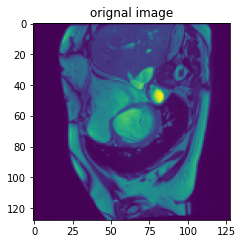

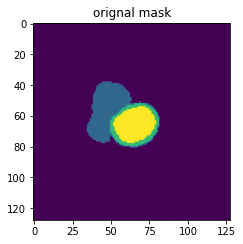

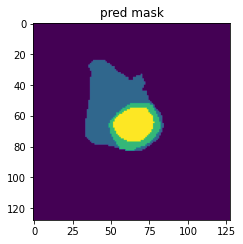

In [55]:
final_image_transpose = torch.squeeze(final_image).cpu().detach().numpy()
                                
final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

pred_image_transpose = torch.squeeze(y_pred_idx).cpu().detach().numpy()


                                
                                
plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(final_image_transpose)
plt.title('orignal image')

plt.figure(figsize = (12,4))
plt.subplot(1,3,2)
plt.imshow(final_mask_transpose)
plt.title('orignal mask')

plt.figure(figsize = (12,4))
plt.subplot(1,3,3)
plt.imshow(pred_image_transpose)
plt.title('pred mask')